In [2]:
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(color_codes=True)
sns.set(style="darkgrid")
style.use('seaborn-bright')

# drop simple_journal after converting to is_fraud
# Use CVC responsecode unknown as variable? False = CVCR_False, True = CVCR_True, unknown = CVCR_Unknown? convert to oneh?
# use functions for assessment

### Preprocessing 
We pre-process the dataset to prepare for visualization

- 1 Remove Refused transactions.
- 2 Empty cvc codes are converted to False values.
- 3 Add amount_converted column with GBP amount.
- 4 If issuercountrycode or shoppercountrycode is NaN fill it with the other.
- 5 Map cvc response codes from 0-6 to 0-3 using: 0:0, 1:1, 2:2, 3:3, 4:3, 5:3, 6:3.
- 6 Add boolean is_fraud column

In order to skip all preprocessing functions we can import the processed data from preprocess.csv

In [34]:
df = pd.read_csv('preprocess.csv')
df.bookingdate = pd.to_datetime(df.bookingdate)
df.creationdate = pd.to_datetime(df.creationdate)

If you want to process the file from the originally supplied file use the following code.

Read out the data from the data_for_student_case.csv and start preprocessing.

In [73]:
df = pd.DataFrame(pd.read_csv('data_for_student_case.csv'))

# Convert dates to actual datetime format
df.bookingdate = pd.to_datetime(df.bookingdate)
df.creationdate = pd.to_datetime(df.creationdate)

# Remove the refused transactions
df = df[df['simple_journal'] != 'Refused']

# Fill cardverificationcodesupplied NaN values with False
df.cardverificationcodesupplied.fillna(value=False, inplace=True)

def convert_currency(row):
    """
    Function for converting the amount to GBP
    """
    coversion_dict = {'SEK':0.08766,'MXN':0.04057,'AUD':0.5715,'NZD':0.5327,'GBP':1}
    currency = row['currencycode']
    amount = row['amount']
    return round(amount * coversion_dict[currency])

def fix_countrycodes(row):
    """
    Function that fills in issuercountrycode or shoppercountrycode in the other if one of both is missing
    """
    if pd.isnull(row.issuercountrycode):
        row.issuercountrycode = row.shoppercountrycode
    elif pd.isnull(row.shoppercountrycode):
        row.shoppercountrycode = row.issuercountrycode
    return row
    
def changerows(row):
    """
    Function that takes in the rows and performs operations on it
    """
    if row.txid % 50000 == 0:
        print(row)
        
    # Now we add a column to all the data containing the transacted amount in GBP. 
    row['amount_convert'] = convert_currency(row)
    
    # if countrycodes are NaN use the code of the issuer/shoppercountry 
    row = fix_countrycodes(row)
    
    # map cvc response code to 0,1,2,3
    map_cvc = {0:0, 1:1, 2:2, 3:3, 4:3, 5:3, 6:3}
    
    row['cvcresponsecode'] = map_cvc[row['cvcresponsecode']]
    # Add is_fraud column for ease of use
    row['is_fraud'] = row['simple_journal'] == 'Chargeback'
    return row

# Perform the changerows function on all rows
df = df.apply(changerows, axis=1)
df.drop(['simple_journal', 'amount'], axis=1, inplace=True)

# Should be no more missing values
print(f'Total missing values: {df.isnull().values.sum()}\n')

df.head()
# Write to csv
# df.to_csv('preprocess.csv')

txid                                         250000
bookingdate                     2015-07-29 00:21:38
issuercountrycode                                GB
txvariantcode                             visadebit
bin                                          476367
amount                                        16000
currencycode                                    GBP
shoppercountrycode                               GB
shopperinteraction                        Ecommerce
simple_journal                              Settled
cardverificationcodesupplied                   True
cvcresponsecode                                   1
creationdate                    2015-07-26 21:03:45
accountcode                               UKAccount
mail_id                                 email107801
ip_id                                      ip296877
card_id                                  card153407
Name: 98638, dtype: object
txid                                         300000
bookingdate                     2015-

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id,amount_convert,is_fraud
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798,2629,True
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595,1822,True
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142,6081,True
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744,4459,True
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271,3647,True


Using the preprocessed data, the categorical variables are converted into one hot encoding. Per categorical variable we look at the implementation of hash encoding and if this improves performance. Only for the issuercountrycode and the shoppercountrycode using a has encoding improved the amount of columns used. For both categories a hash of size 5 was sufficient to keep all information. 

Columns in dataframe without processing: 17.
Columns in dataframe with preprocessing: 270.

In [35]:
# convert columns with categorical value to one hot encoded using a hash function
def cat_to_oneh(dataframe, column, hashsize):
    """
    Function for changing a column with categorical variables into multiple one hot encoded columns using hashes
    """
    df1 = df[column].copy()
    print(len(df1))
    df1 = df1.apply(lambda x: str(hash(x))[1:hashsize])
    df1 = pd.DataFrame(df1.str.split('').tolist())
    df1 = df1.drop([0, hashsize], axis=1)
    df1 = pd.get_dummies(df1)
    df1.columns = [column + '_' + x for x in df1.columns]
    df1.reset_index(inplace=True)
    return df1

cat_cols = ['issuercountrycode', 'txvariantcode', 'currencycode', 'shoppercountrycode',
                        'shopperinteraction', 'accountcode', 'cvcresponsecode']
col_amounts = [1,0,0,1,0,0,0]
df.reset_index(inplace=True)
index = 0
for col in cat_cols:
    if col_amounts[index]:
        df = pd.concat([df, cat_to_oneh(df, col, 6)], axis=1)
    else:
        df = pd.concat([df, pd.get_dummies(df[col])], axis=1)
    index += 1
    df.drop(col, axis=1, inplace=True)
df.rename(columns={0:'cvcresp0', 1:'cvcresp1', 2:'cvcresp2', 3:'cvcresp3'}, inplace=True)  
df.drop('index', 'Unnamed: 0', , axis=1, inplace=True)


237036
237036


In [37]:
for col in df.columns:
    print(col)

index
Unnamed: 0
txid
bookingdate
bin
amount
simple_journal
cardverificationcodesupplied
creationdate
mail_id
ip_id
card_id
amount_convert
is_fraud
index
issuercountrycode_1_0
issuercountrycode_1_1
issuercountrycode_1_2
issuercountrycode_1_3
issuercountrycode_1_4
issuercountrycode_1_5
issuercountrycode_1_6
issuercountrycode_1_7
issuercountrycode_1_8
issuercountrycode_1_9
issuercountrycode_2_0
issuercountrycode_2_1
issuercountrycode_2_2
issuercountrycode_2_3
issuercountrycode_2_4
issuercountrycode_2_5
issuercountrycode_2_6
issuercountrycode_2_7
issuercountrycode_2_8
issuercountrycode_2_9
issuercountrycode_3_0
issuercountrycode_3_1
issuercountrycode_3_2
issuercountrycode_3_3
issuercountrycode_3_4
issuercountrycode_3_5
issuercountrycode_3_6
issuercountrycode_3_7
issuercountrycode_3_8
issuercountrycode_3_9
issuercountrycode_4_0
issuercountrycode_4_1
issuercountrycode_4_2
issuercountrycode_4_3
issuercountrycode_4_4
issuercountrycode_4_5
issuercountrycode_4_6
issuercountrycode_4_7
issuercoun

In [39]:

df_export.to_csv('processed_data.csv')

# Visualization
Using the preprocessed data visualization is started. The final graphs used are:
- 1: Fraud vs Amounts.
- 2: 

C:\Users\mbezema\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


mean: 
#is_fraud
False     18888.996037
True     105137.652174
Name: amount, dtype: float64

std: 
#is_fraud
False     41342.000541
True     124188.477258
Name: amount, dtype: float64

max amount: 
#is_fraud
False    1955765.0
True      769500.0
Name: amount, dtype: float64



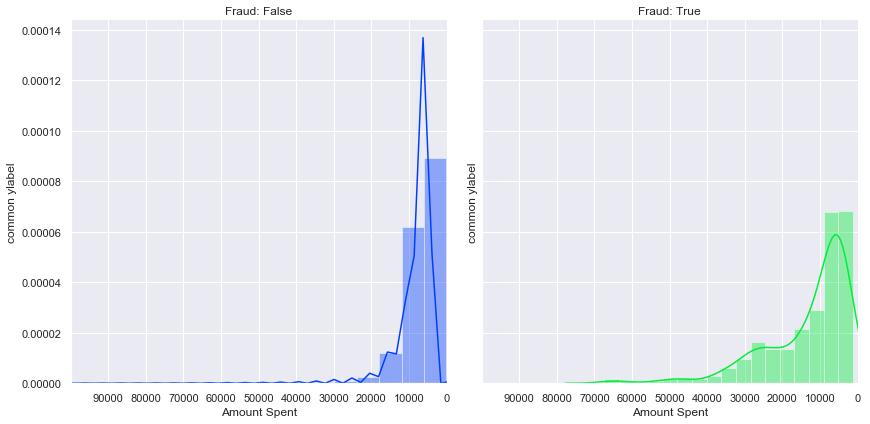

In [10]:
## Visualize fraud vs amounts
g = sns.FacetGrid(df, col="is_fraud", size=6, hue='is_fraud', sharex=True, xlim=100000)
g.map(sns.distplot,"amount_convert", kde=True)
g.set(xticks=range(0,100000, 10000))
g.set_titles('Fraud: {col_name}')
g.set(xlabel='Amount Spent', ylabel='common ylabel')

print(f"mean: \n#{df.groupby(by=['is_fraud'])['amount'].mean()}\n")
print(f"std: \n#{df.groupby(by=['is_fraud'])['amount'].std()}\n")
print(f"max amount: \n#{df.groupby(by=['is_fraud'])['amount'].max()}\n")

Form the plots above we can see that the transacted amount for fraud transactions is higher on average than the non fraud ones, and also contain more outliers for the higher amounts.

Looking at the numerical values of the mean and deviation the transacted amounts we see confirmation that the mean amount of fraudulent transactions is much higher than non-fraudulent ones, mainly caused by large outliers.


/usr/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


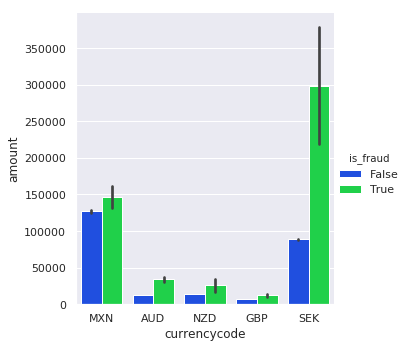

In [16]:

sns.factorplot(data=df, kind='bar', x="currencycode", y="amount", hue="is_fraud")


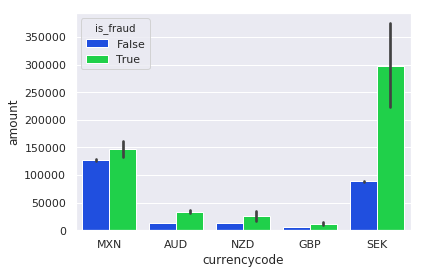

In [17]:
# Bar plot of fraud vs legit transations per currencycode
sns.barplot(data=df, x="currencycode", y="amount", hue="is_fraud")

ValueError: Could not interpret input 'amount_convert'

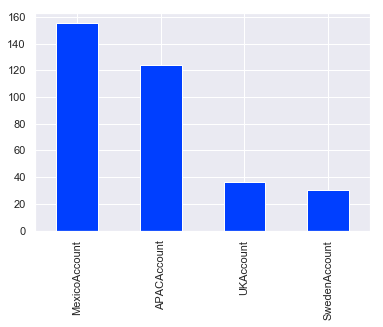

<Figure size 432x288 with 0 Axes>

In [16]:
# Amount of fraudulent tranactions per account code
# MexicoAccount has by far the most fraudulent transations, but the amounts are much lower per fraudulent transaction.
# SwedenAccount has the lowest number of fraudulent txs, but the amount of money involved is the highest
df = pd.read_csv('data_for_student_case.csv')
df['is_fraud'] = df.simple_journal.apply(lambda x:  x == 'Chargeback')
fraudulent = df[df["is_fraud"] == 1]
plt.figure()
fraudulent['accountcode'].value_counts().plot(kind='bar')
plt.figure()
sns.barplot(data=df, x="accountcode", y="amount_convert", hue="is_fraud")

In [14]:
# same visualisation as above but with txvariantcode.
# Mccredit has the highest num of fraud tx but not the highest amount, although there are some with way less
# plt.figure()
fraudulent['txvariantcode'].value_counts().plot(kind='bar')
plt.xticks(rotation=45)
plt.figure()
g = sns.barplot(data=df, x="txvariantcode", y="amount_convert", hue="is_fraud")
g.set_xticklabels(rotation=30)

KeyError: 'txvariantcode'

<Figure size 432x288 with 0 Axes>

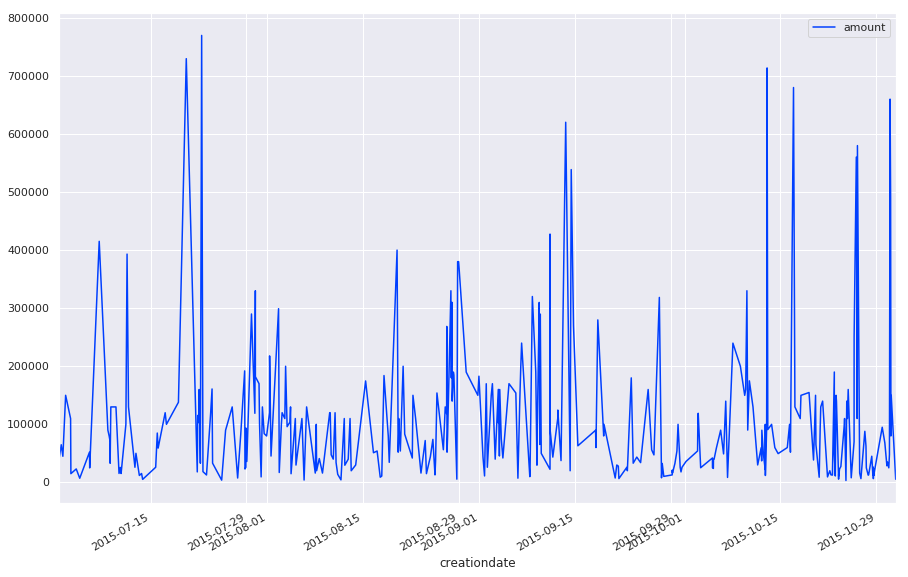

In [20]:
# Amount of fraud over time shows a very small decline in the amount of fraud committed over time.
fraudulent = df[df["is_fraud"] == 1]
len(fraudulent)

# attempt 1
# sns.lineplot(x="bookingdate", y="amount", data=fraudulent.sort_index(by='bookingdate'))

#attempt 2
# fraudulent.set_index("bookingdate").groupby(pd.Grouper(freq='M')).head()
# plt = sns.lineplot(x="creationdate", y="amount", data=gr)
# plt.xticks(rotation=70)

#attempt 3
plt.figure();
fraudulent.set_index("creationdate").plot(figsize=(15,10), y='amount')

In [21]:
# amount of fraud per month of the year, no idea how to make a bar plot of this..
fraudulent = df[df["is_fraud"] == 1]
monthly = fraudulent['amount'].groupby(df['bookingdate'].dt.month).mean()

monthly = df.groupby(df['bookingdate'].dt.month).mean()


spent_in_issue_country  is_fraud
False                   False         6531
                        True            14
True                    False       230160
                        True           331
Name: is_fraud, dtype: int64


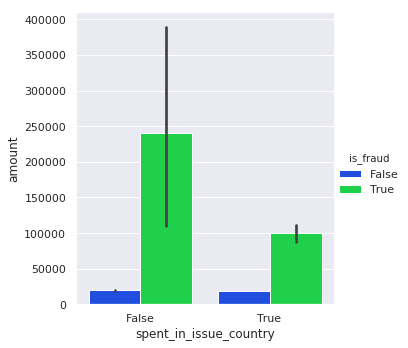

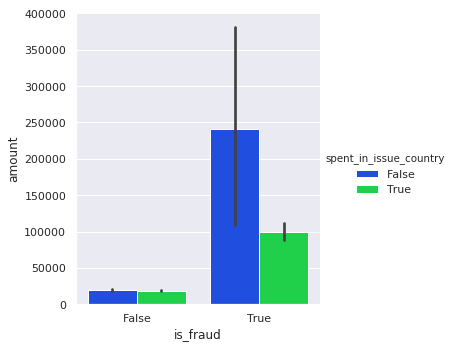

In [23]:
# Attempting to explore is theres a higher chance of fraud when issuercountrycode != shoppercountrycode

is_equal = df[df['issuercountrycode'] == df['shoppercountrycode']]
not_equal = df[df['issuercountrycode'] != df['shoppercountrycode']]

spent_in_issue_country = df['issuercountrycode'] == df['shoppercountrycode']
df['spent_in_issue_country'] = spent_in_issue_country
# sns.barplot(data=is_equal, x="currencycode", y="amount", hue="is_fraud")
# sns.barplot(data=df, x="currencycode", y="amount", hue="is_fraud")

# is_equal['is_fraud']
# fig1, ax1 = plt.subplots()
# ax1.pie(is_equal['is_fraud'], labels=['is fraud', 'is not fraud'], autopct='%1.1f%%', shadow=True)
# ax1.axis('equal')
# plt.show()
# df.plot(kind='pie', y='amount')

sns.factorplot(data=df, kind='bar', x="spent_in_issue_country", y="amount", hue="is_fraud")
sns.factorplot(data=df, kind='bar', x="is_fraud", y="amount", hue="spent_in_issue_country")

group = df.groupby(["spent_in_issue_country", "is_fraud"])["is_fraud"].count()
# group[0].plot.bar(title="spent_in_issue_country=False")
# group[1].plot.bar(title="spent_in_issue_country=True")

# group[0].plot.pie(subplots=True)
print(group)

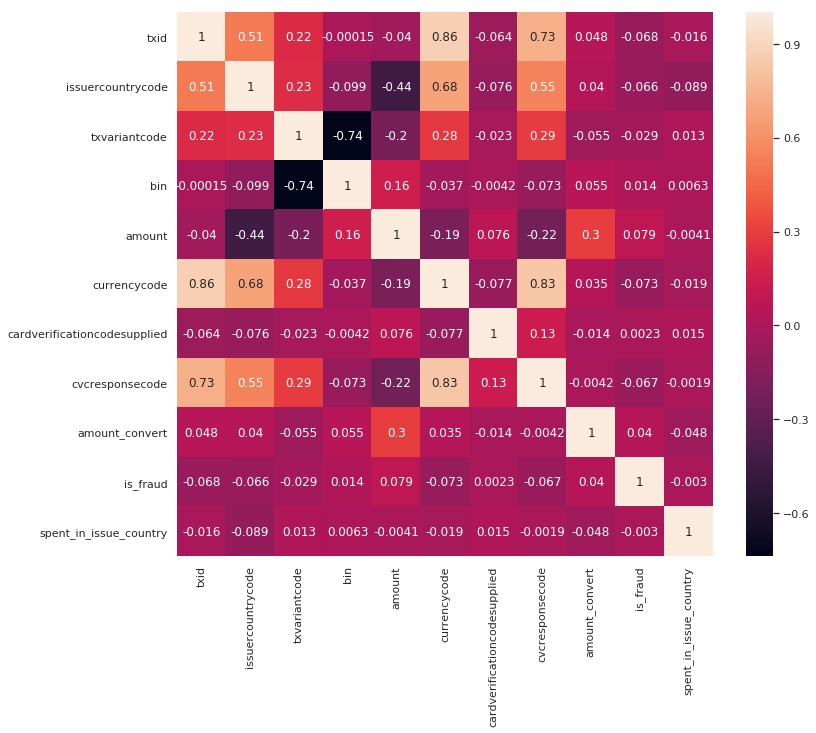

In [24]:
# Heatmap, only numerical data is taken into account, 
# may need to encode some data to add exra columns <- may cause wrong correlations?
# is_fraud appears to have extremely low correlation with all other columns, 
# especially the column of interest 'is_fraud'

def create_list_mapping(somelist):
    # takes a list eg ["A", "B"] and maps it to a dict eq {"A": 0, "B": 1}
    return {x:somelist.tolist().index(x) for x in somelist}

issuercountrycode_map = create_list_mapping(df['issuercountrycode'].unique())
txvariantcode_map = create_list_mapping(df['txvariantcode'].unique())
currencycode_map = create_list_mapping(df['currencycode'].unique())

df_remapped = df.replace(issuercountrycode_map)
df_remapped = df_remapped.replace(txvariantcode_map)
df_remapped = df_remapped.replace(currencycode_map)

plt.figure(figsize=(12,10))
sns.heatmap(df_remapped.corr(), annot=True)

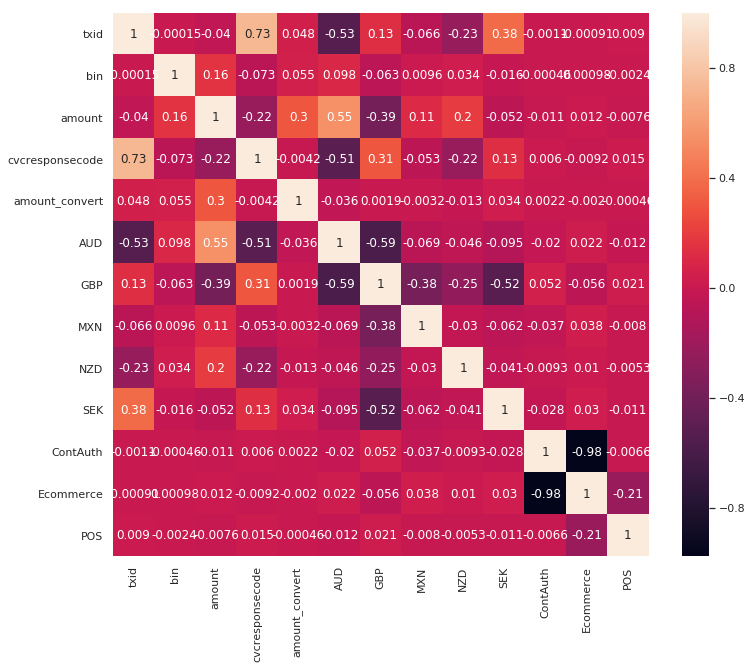

In [25]:
## Heatmap with onehotencoding
df_onehot = df.copy()
df_onehot.head()
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb_results = lb.fit_transform(df['currencycode'])
lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)
df_onehot = pd.concat([df_onehot, lb_results_df], axis=1)

lb_results = lb.fit_transform(df['shopperinteraction'])
lb_results_df = pd.DataFrame(lb_results, columns=lb.classes_)
df_onehot = pd.concat([df_onehot, lb_results_df], axis=1)

plt.figure(figsize=(12,10))
sns.heatmap(df_onehot.corr(), annot=True)

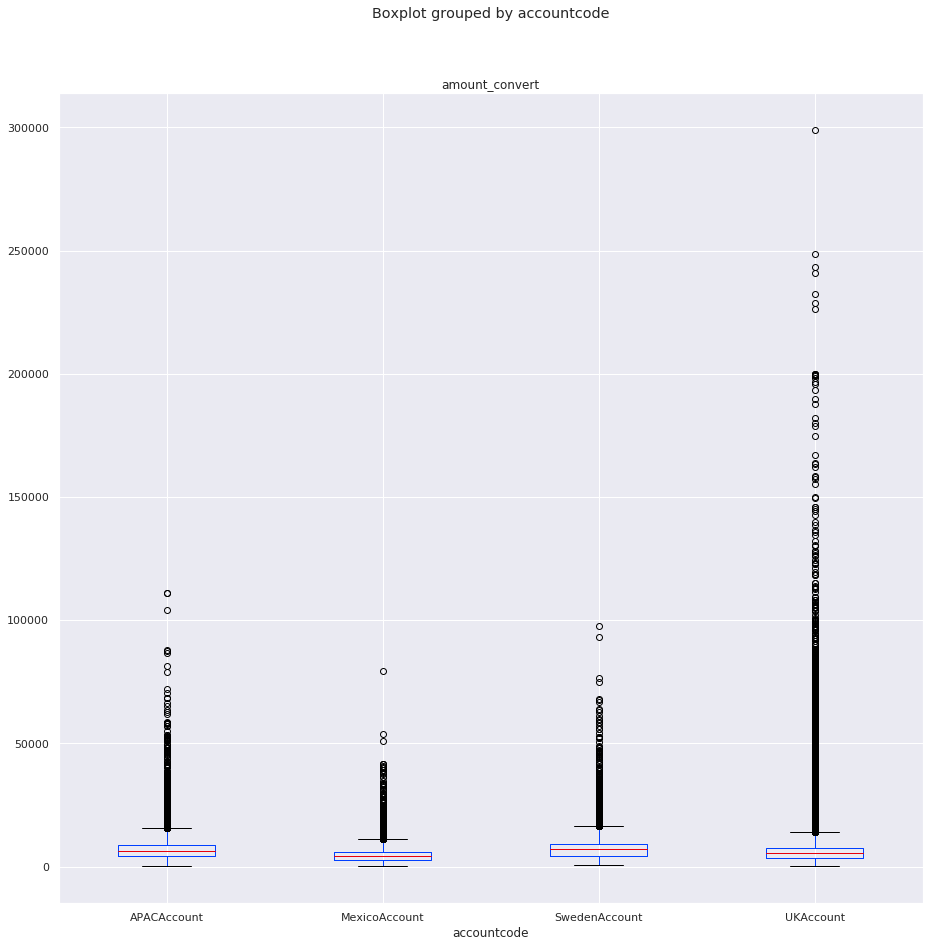

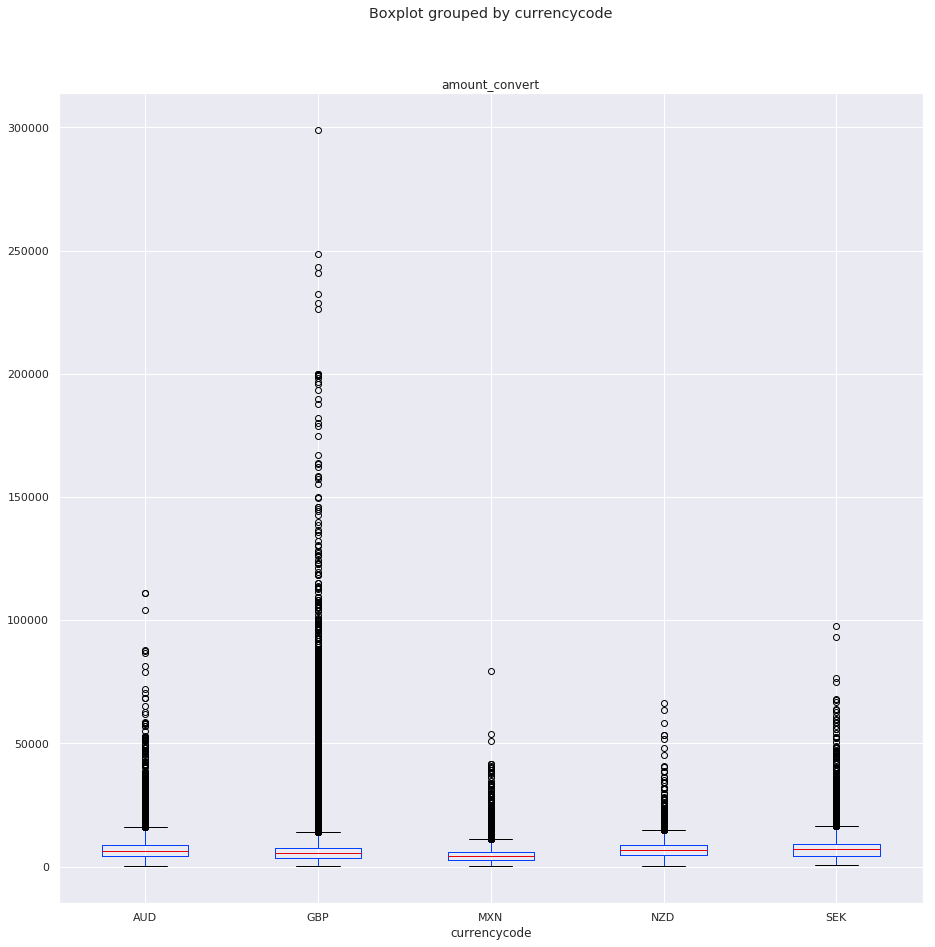

In [28]:
df.boxplot('amount_convert', 'accountcode', figsize=(15,15))
df.boxplot('amount_convert', 'currencycode', figsize=(15,15))

In [30]:
# No card verification code supplied has no cases of fraud,
df_unclean['hascardverification'] = df_unclean['cardverificationcodesupplied'].apply(lambda x: isinstance(x, int))
sns.factorplot(data=df_unclean, kind='bar', x="hascardverification", y="amount", hue='is_fraud')

df_unclean.groupby([df_unclean['hascardverification'], df['is_fraud']]).count()

ValueError: Could not interpret input 'is_fraud'

## Imbalance Task
Process the data such that you can apply SMOTE to it. SMOTE is included in most analysis platforms, if not you can write the scripts for it yourself. Analyze the performance of at least three classifiers on the SMOTEd and UNSMOTEd data using ROC analysis. Provide the obtained ROC curves and explain which method performs best. Is using SMOTE a good idea? Why (not)

Classifiers:
- Random Forest
- Logistic Regression 
- Support Vector Machine

## Smote

In [25]:
# Applying smote
from imblearn.over_sampling import SMOTE

def apply_smote(columns, data, fraud_rows):
#     print(data['is_fraud'].value_counts())

    smt = SMOTE(random_state=0)
    X_train, y_train = smt.fit_sample(data[columns], fraud_rows)

    print(np.bincount(y_train))
    
    return X_train, y_train 


## Spliting into test and training set

In [19]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

def split_data(x, y):
    values_to_predict = np.array(y)

    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(
        x, values_to_predict, test_size = 0.25, random_state = 42)
    
    return train_features, test_features, train_labels, test_labels

## Random Forrest

In [20]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

def random_forrest(train_features, test_features, train_labels, test_labels):
    # Instantiate model with 1000 decision trees
    rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
    # Train the model on training data
    rf.fit(train_features, train_labels);
    # Use the forest's predict method on the test data
    predictions = rf.predict(test_features)
    # Calculate the absolute errors
    errors = abs(predictions - test_labels)
    return predictions, errors

# Metrics for assessing classifiers

In [21]:
def plot_roc_curve(fpr, tpr):  
    plt.figure(figsize=(12,8), dpi=300)
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    return plt

def get_metric(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f'True Neg: {tn}, False pos: {fp}, False neg: {fn}, True pos: {tp}')
    return (tn, fp, fn, tp)

Get dataset ready for algorithms

In [30]:
df.columns

Index(['index', 'Unnamed: 0', 'txid', 'bookingdate', 'bin', 'amount',
       'simple_journal', 'cardverificationcodesupplied', 'creationdate',
       'mail_id',
       ...
       'Ecommerce', 'POS', 'APACAccount', 'MexicoAccount', 'SwedenAccount',
       'UKAccount', 'cvcresp0', 'cvcresp1', 'cvcresp2', 'cvcresp3'],
      dtype='object', length=145)

In [31]:
from sklearn.metrics import roc_curve  
from sklearn.metrics import roc_auc_score  
fraud_rows = df['is_fraud']
df_exp = df.drop(["bookingdate", "creationdate", 
                  "simple_journal", 
                  "mail_id", 
                  "ip_id", 
                  "card_id",
                  "is_fraud",
                  "txid"], axis = 1)
cols = list(df_exp.columns)
# apply smote and splitting
# train_features, test_features, train_labels, test_labels = split_data(X_train, y_train)
train_features, test_features, train_labels, test_labels = split_data(df_exp, df['is_fraud'])
X_train, y_train = apply_smote(cols, train_features, train_labels)

[177522 177522]


Apply algorithms

In [33]:
# predictions, errors = random_forrest(X_train, test_features, y_train, test_labels)
# # get_metric(y_true, y_pred)
# auc = roc_auc_score(test_labels, predictions)  
# print('AUC: %.2f' % auc)  
# fpr, tpr, thresholds = roc_curve(test_labels, predictions)  
# plot_roc_curve(fpr, tpr).show()

In [ ]:
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

def perform_pca(variables, components):
    return PCA(n_components=components).fit_transform(variables)

def neural_net(x_train_smoted, y_train_smote, x_test, y_test, x_train, y_train):
    X_pca_train = perform_pca(x_train_smoted, 3)
    X_pca_test = perform_pca(x_test, 3)
    mlp = MLPClassifier(solver='lbfgs', alpha=0.1, hidden_layer_sizes=(15,), random_state=0)
    mlp.fit(X_pca_train, y_train_smote)
    predicted = mlp.predict(X_pca_test)
#     predicted_prob = mlp.predict_proba(X_pca_test)
    

In [ ]:
#train_features, test_features, train_labels, test_labels
X_train, y_train = x_train, y_train
get_metric(y_true, y_pred)
auc = roc_auc_score(test_labels, predictions)  
print('AUC: %.2f' % auc)  
fpr, tpr, thresholds = roc_curve(test_labels, predictions)  
plot_roc_curve(fpr, tpr).show()

Calculate scores